In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import sys

from keras_preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras.applications.vgg19 import VGG19
from sklearn.metrics import *

sys.path.append('../usr/lib/eval-utils-nih')

import eval_utils_nih as eu

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2156)              54091884  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2156)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1280)              2760960   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0

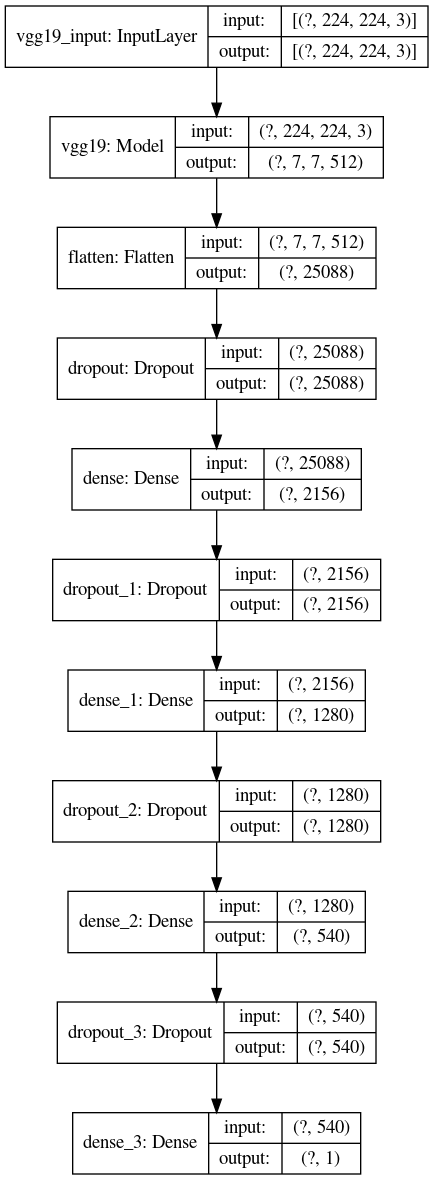

In [2]:
model = eu.load_model('../input/model-training-model-1', 'model.h5')

model.summary()

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [3]:
input_dir = '/kaggle/input'

sample_dir = os.path.join(input_dir, 'sample/')
csv_dir = os.path.join(input_dir, 'nihsample')
images_dir = os.path.join(sample_dir, 'sample/sample/images')

In [4]:
testing_file = os.path.join(csv_dir, 'test_data.csv')

testing_df = pd.read_csv(testing_file, index_col=0)

testing_df['pneumonia'] = testing_df['pneumonia'].astype(str)

In [5]:
batch_size = 64
image_size = (224, 224)

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=testing_df,
    directory=images_dir,
    x_col="image_index",
    y_col='pneumonia',
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode='binary',
    target_size=image_size,
    color_mode='rgb'
)

Found 1121 validated image filenames belonging to 2 classes.


In [6]:
eu.evaludate_model_n_print_loss_n_acc(model, test_generator)

18/18 [==============================] - 23s 1s/step - loss: 0.5897 - accuracy: 0.6539

Loss: 0.590
Accuracy: 65.388%


In [7]:
test_preds = model.predict(test_generator, verbose=1)

18/18 [==============================] - 21s 1s/step


In [8]:
classes = ['NORMAL', 'PNEUMONIA']

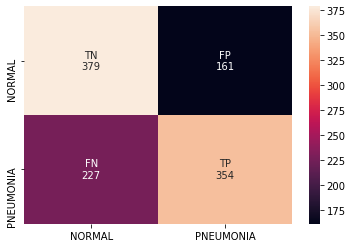

In [9]:
eu.draw_confusion_matrix_by_data_generator_n_predictions(
    test_generator,
    np.rint(test_preds),
    classes,
    cmap=None
)

In [10]:
eu.generate_classification_report(
    test_generator,
    np.rint(test_preds),
    classes
)

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.63      0.70      0.66       540
   PNEUMONIA       0.69      0.61      0.65       581

    accuracy                           0.65      1121
   macro avg       0.66      0.66      0.65      1121
weighted avg       0.66      0.65      0.65      1121



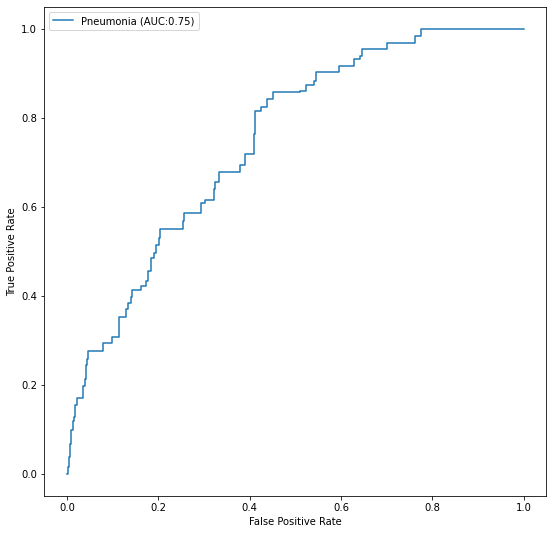

In [11]:
eu.plot_roc_curve(test_generator.classes, test_preds)

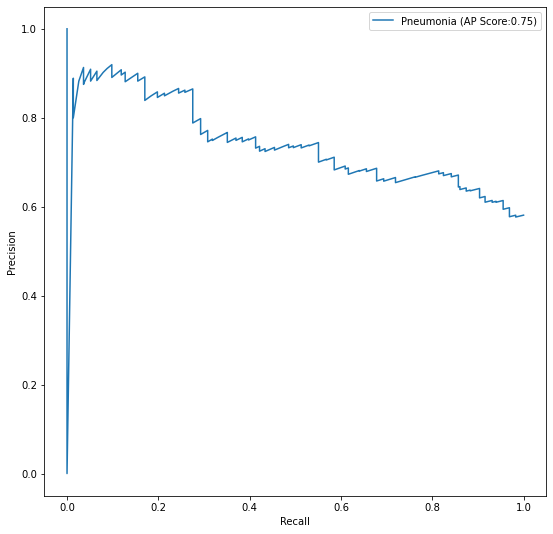

In [12]:
eu.plot_precision_recall_curve(test_generator.classes, test_preds)

Best Threshold=0.468323, G-Mean=0.692


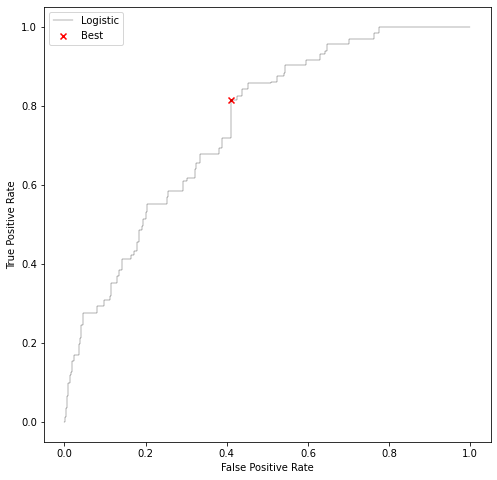

In [13]:
fpr, tpr, thresholds = roc_curve(test_generator.classes, test_preds)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)

print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr, label='Logistic', color='k', linewidth=0.3)
plt.scatter(fpr[ix], tpr[ix], marker='x', color='r', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()